In [6]:
import openfermionpyscf as ofpyscf
import openfermion as of
import cirq
import openfermioncirq as ofc
import numpy as np
import pyscf
from openfermion.transforms import get_fermion_operator, jordan_wigner, bravyi_kitaev

In [7]:
diatomic_bond_length = .7414
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., diatomic_bond_length))]
basis = 'sto-3g'
multiplicity = 1
charge = 0
description = str(diatomic_bond_length)

In [8]:
from openfermion.hamiltonians import MolecularData
molecule = MolecularData(geometry, basis, multiplicity, charge)
h2_molecule = ofpyscf.run_pyscf(molecule, run_mp2=True, run_cisd=True, run_ccsd=True, run_fci=True)
elektron=h2_molecule.n_electrons
orbitals = h2_molecule.n_orbitals
qubit= h2_molecule.n_qubits

In [9]:
from openfermion.utils import uccsd_singlet_generator
initial_amplitudes = np.linspace(0,0.05677,2)
#membuat ansatz UCCSD
uccsd_fermion=uccsd_singlet_generator(initial_amplitudes,qubit,elektron)
print(uccsd_fermion)

-0.05677 [0^ 2 1^ 3] +
-0.05677 [1^ 3 0^ 2] +
0.05677 [2^ 0 3^ 1] +
0.05677 [3^ 1 2^ 0]


In [10]:
# ansatz dirubah dari fermion operator menjadi qubit operator
uccsd_jw=jordan_wigner(uccsd_fermion)
print(uccsd_jw)

-0.0141925j [X0 X1 X2 Y3] +
-0.0141925j [X0 X1 Y2 X3] +
0.0141925j [X0 Y1 X2 X3] +
-0.0141925j [X0 Y1 Y2 Y3] +
0.0141925j [Y0 X1 X2 X3] +
-0.0141925j [Y0 X1 Y2 Y3] +
0.0141925j [Y0 Y1 X2 Y3] +
0.0141925j [Y0 Y1 Y2 X3]


In [11]:
class MyAnsatz(ofc.VariationalAnsatz):

    def params(self):
        """The parameters of the ansatz."""
        return [cirq.Symbol('theta_0')]

    def operations(self, qubits):
        """Produce the operations of the ansatz circuit."""
        q0, q1, q2, q3 = qubits
        yield cirq.H(q0), cirq.H(q1), cirq.H(q2)
        yield cirq.XPowGate(exponent=-0.5).on(q3)

        yield cirq.CNOT(q0, q1), cirq.CNOT(q1, q2), cirq.CNOT(q2, q3)
        yield cirq.ZPowGate(exponent=cirq.Symbol('theta_0')).on(q3)
        yield cirq.CNOT(q2, q3), cirq.CNOT(q1, q2), cirq.CNOT(q0, q1)

        yield cirq.H(q0), cirq.H(q1), cirq.H(q2)
        yield cirq.XPowGate(exponent=0.5).on(q3)

    def _generate_qubits(self):
        """Produce qubits that can be used by the ansatz circuit."""
        return cirq.LineQubit.range(4)

In [12]:
FungsiCoba=MyAnsatz()

In [13]:
bond_length_interval = 0.1
n_points = 25

CCSD=. -0.6018037168042082
Nilai optimum: -0.6018037090636165
CCSD=. -0.9141497080889696
Nilai optimum: -0.9141497017796381
CCSD=. -1.05515979649697
Nilai optimum: -1.0551597905688876
CCSD=. -1.1162860078288028
Nilai optimum: -1.116286002729829
CCSD=. -1.1361894542843936
Nilai optimum: -1.1361894535902635
CCSD=. -1.1341476664304937
Nilai optimum: -1.134147663903087
CCSD=. -1.120560280971827
Nilai optimum: -1.1205602804695842
CCSD=. -1.101150330871435
Nilai optimum: -1.1011503302056609
CCSD=. -1.0791929438391945
Nilai optimum: -1.0791929439691703
CCSD=. -1.0567407449167354
Nilai optimum: -1.0567407462012361
CCSD=. -1.0351862642484724
Nilai optimum: -1.0351862658679254
CCSD=. -1.0154682441838383
Nilai optimum: -1.0154682490093838
CCSD=. -0.9981493526444732
Nilai optimum: -0.9981493534710977
CCSD=. -0.9834727288833649
Nilai optimum: -0.9834727275154289
CCSD=. -0.9714266897613956
Nilai optimum: -0.9714266884322889
CCSD=. -0.9618169564719969
Nilai optimum: -0.9618169525614296
CCSD=. -0.9543

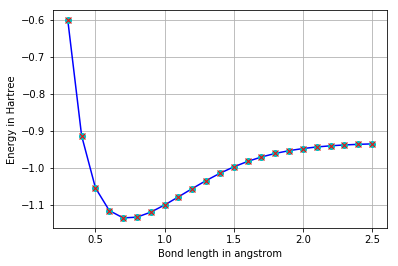

In [16]:
ccsd_energies = []
fci_energies=[]
vqe_uccsd_energies = []
bond_lengths = []
hf_energies =[]
for point in range(3, n_points + 1):
    bond_length = bond_length_interval * point
    bond_lengths += [bond_length]
    description = str(round(bond_length,2))
    #print("Jarak Antar Atom=",description)
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    molecule1 = MolecularData(
        geometry, basis, multiplicity, description=description)
    molecule1.load()
    hamiltonian = ofpyscf.generate_molecular_hamiltonian(geometry, basis, multiplicity, charge)
    #print(hamiltonian)
    hamiltonan_jw=jordan_wigner(hamiltonian)
    #print("H_JW=",hamiltonan_jw)
    #mendeklarasikan Hamiltonan yang akan ditinjau
    objektif = ofc.HamiltonianObjective(hamiltonan_jw)

    #membuat keadaan referensi
    q0, q1, _, _ = FungsiCoba.qubits
    keadaan_refensi = cirq.Circuit.from_ops(cirq.X(q0), cirq.X(q1))


    study = ofc.VariationalStudy(name='VQE JW Hidrogen',ansatz=FungsiCoba,objective=objektif,preparation_circuit=keadaan_refensi)
    #optimasi
    algoritma = ofc.optimization.ScipyOptimizationAlgorithm(kwargs={'method': 'nelder-mead'},options={'maxiter': 100})


    optimization_params = ofc.optimization.OptimizationParams(algorithm=algoritma,initial_guess=FungsiCoba.default_initial_params())
    result = study.optimize(optimization_params)
    print("CCSD=.",molecule1.ccsd_energy)
    print('Nilai optimum: {}'.format(result.optimal_value))
    #print("parameter optimasinya:")
    #print(result.optimal_parameters)
    ccsd_energies += [molecule1.ccsd_energy]
    fci_energies += [molecule1.fci_energy]
    vqe_uccsd_energies += [result.optimal_value]
    hf_energies += [molecule1.hf_energy]
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(0)
plt.plot(bond_lengths, ccsd_energies, 'b-')
plt.plot(bond_lengths, vqe_uccsd_energies, 'co')
plt.plot(bond_lengths, fci_energies,'rx')
plt.grid()
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.show()

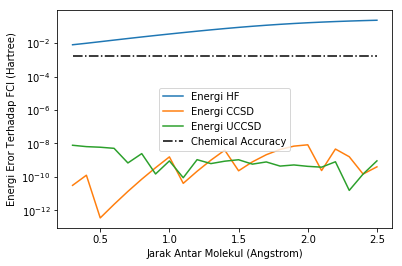

In [18]:
import matplotlib.pyplot as plt
plt.figure()
plt.semilogy(bond_lengths,np.abs(np.subtract(fci_energies,hf_energies)),label='Energi HF')
plt.semilogy(bond_lengths,np.abs(np.subtract(fci_energies,ccsd_energies)),label='Energi CCSD')
plt.semilogy(bond_lengths,np.abs(np.subtract(fci_energies,vqe_uccsd_energies)),label='Energi UCCSD')
plt.semilogy(bond_lengths,0.0016*np.ones([len(bond_lengths),1]),label='Chemical Accuracy',linestyle='-.',color='black')
plt.xlabel('Jarak Antar Molekul (Angstrom)')
plt.ylabel('Energi Eror Terhadap FCI (Hartree)')
#plt.title('Error Terhadap FCI - Disassociation curve hydrogen molecule')
plt.legend()